# Hourly Electricity Load Forecasting (PJM)

This project forecasts hourly electricity demand (MW) for the PJM Interconnection using historical load data.

The goal is to apply time-series feature engineering and machine learning (Random Forest) to model and predict short-term electricity load.

## Dataset
- **Source:** PJM Interconnection
- **Frequency:** Hourly
- **Target:** `PJM_Load_MW` (load in megawatts)
- **Period:** 1998–present

## Objectives
- Explore trends, seasonality, and volatility in load data
- Create lagged and rolling window features
- Apply time-aware cross-validation (`TimeSeriesSplit`)
- Train and evaluate tree-based model (Random Forest)


In [22]:
import pandas as pd

# Load data
df = pd.read_csv('/.../.../PJM_Load_hourly.csv')  
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Preview
df.head()


,PJM_Load_MW
Datetime,
1998-12-31 01:00:00,29309.0
1998-12-31 02:00:00,28236.0
1998-12-31 03:00:00,27692.0
1998-12-31 04:00:00,27596.0
1998-12-31 05:00:00,27888.0


## Step 3 – Exploratory Data Analysis: Load Trends

We begin by visualizing the hourly electricity load to understand trends, seasonality, and variability.

We’ll also compute rolling statistics to inspect smooth trends and volatility across time.


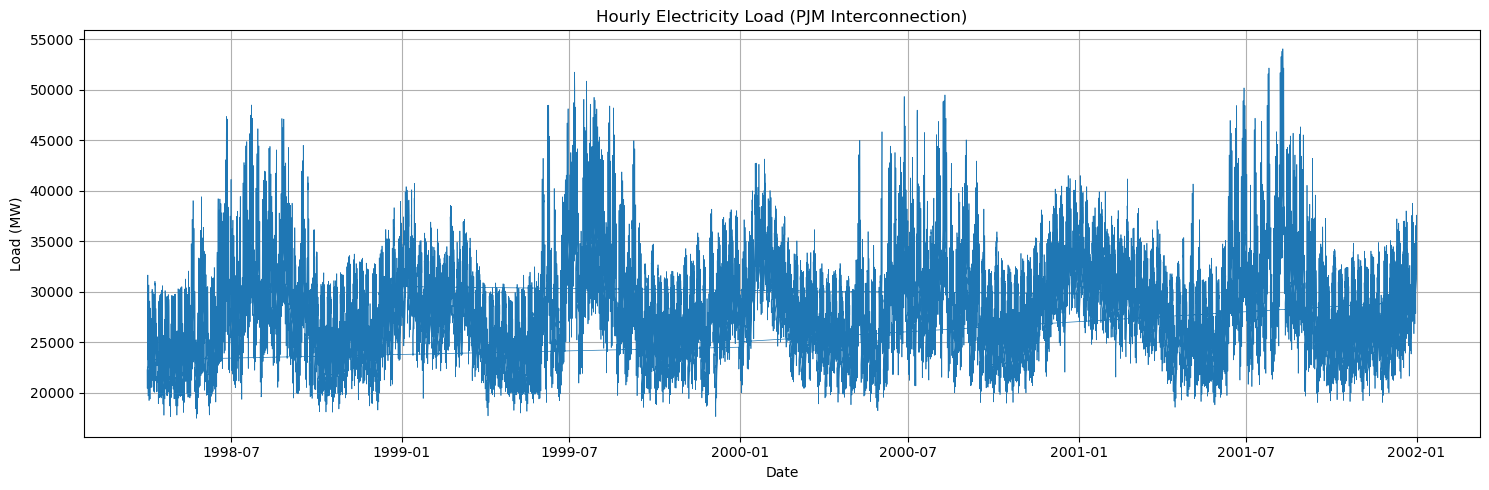

In [23]:
import matplotlib.pyplot as plt

# Full time series plot
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['PJM_Load_MW'], label='Hourly Load (MW)', linewidth=0.5)
plt.title('Hourly Electricity Load (PJM Interconnection)')
plt.ylabel('Load (MW)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


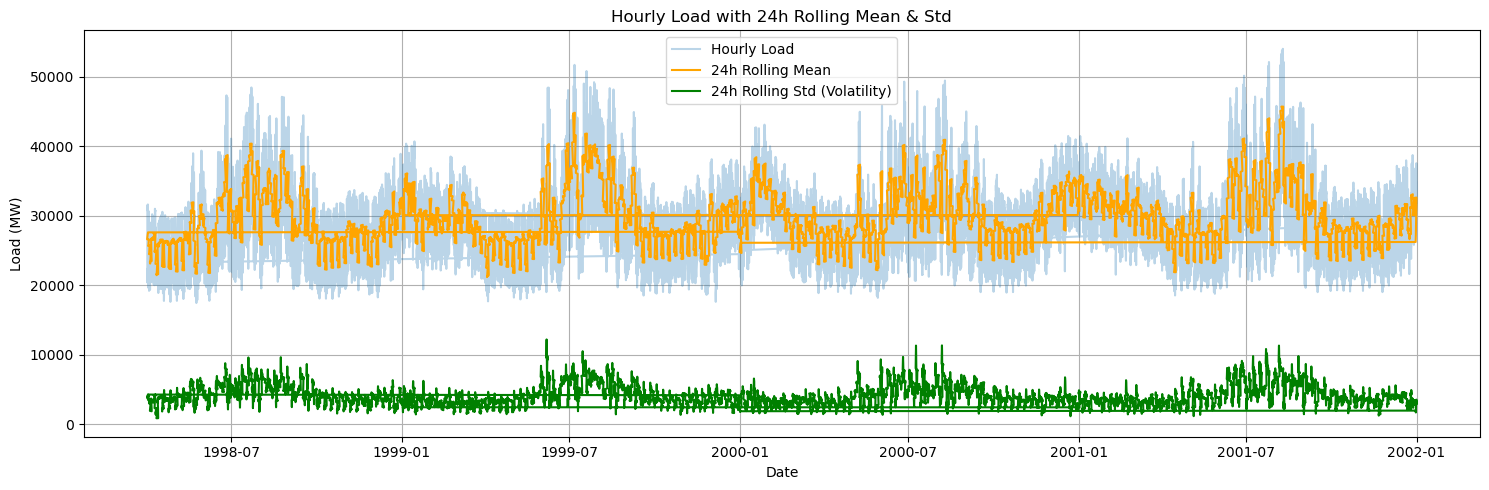

In [24]:
# Add 24-hour (1-day) rolling stats
df['rolling_mean_24h'] = df['PJM_Load_MW'].rolling(24).mean()
df['rolling_std_24h'] = df['PJM_Load_MW'].rolling(24).std()

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['PJM_Load_MW'], label='Hourly Load', alpha=0.3)
plt.plot(df.index, df['rolling_mean_24h'], label='24h Rolling Mean', color='orange')
plt.plot(df.index, df['rolling_std_24h'], label='24h Rolling Std (Volatility)', color='green')
plt.title('Hourly Load with 24h Rolling Mean & Std')
plt.ylabel('Load (MW)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 4 – Feature Engineering: Lags and Rolling Windows

To help the model detect trends and temporal dependencies, we add lagged values and rolling window features.

Features created:
- Lagged load values: 1h, 24h, 168h (1 week)
- Rolling mean and standard deviation over 24h and 168h
- Calendar features: hour of day, day of week


In [25]:
df_feat = df.copy()

# Lag features (previous values)
df_feat['lag_1'] = df_feat['PJM_Load_MW'].shift(1)
df_feat['lag_24'] = df_feat['PJM_Load_MW'].shift(24)
df_feat['lag_168'] = df_feat['PJM_Load_MW'].shift(168)  

# Rolling window statistics
df_feat['rolling_mean_24'] = df_feat['PJM_Load_MW'].rolling(24).mean()
df_feat['rolling_std_24'] = df_feat['PJM_Load_MW'].rolling(24).std()
df_feat['rolling_mean_168'] = df_feat['PJM_Load_MW'].rolling(168).mean()
df_feat['rolling_std_168'] = df_feat['PJM_Load_MW'].rolling(168).std()

# Time-based features
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek  # 0=Mon, 6=Sun

# Drop missing rows
df_feat.dropna(inplace=True)

# Check result
df_feat.head()


,PJM_Load_MW,rolling_mean_24h,rolling_std_24h,lag_1,lag_24,lag_168,rolling_mean_24,rolling_std_24,rolling_mean_168,rolling_std_168,hour,dayofweek
Datetime,,,,,,,,,,,,
1998-12-24 01:00:00,27959.0,27290.333333,1937.670625,27827.0,26854.0,29309.0,27290.333333,1937.670625,29914.041667,3847.661818,1,3
1998-12-24 02:00:00,26474.0,27331.750000,1907.684420,27959.0,25480.0,28236.0,27331.750000,1907.684420,29903.553571,3854.658374,2,3
1998-12-24 03:00:00,25892.0,27383.958333,1846.966219,26474.0,24639.0,27692.0,27383.958333,1846.966219,29892.839286,3863.334195,3,3
1998-12-24 04:00:00,25675.0,27441.125000,1766.959297,25892.0,24303.0,27596.0,27441.125000,1766.959297,29881.404762,3873.003729,4,3
1998-12-24 05:00:00,25921.0,27500.541667,1685.690904,25675.0,24495.0,27888.0,27500.541667,1685.690904,29869.696429,3882.028669,5,3


### Lag Feature Scatter Plots

These scatter plots show how past load values relate to the current load:

- **Lag 1 hour** shows a near-perfect linear correlation, meaning short-term memory is strong.
- **Lag 24 hours** also shows a clear trend, reflecting daily seasonality.
- **Lag 168 hours (1 week)** shows a looser trend, capturing weekly seasonality.

These strong correlations confirm that lag features will be useful for prediction.


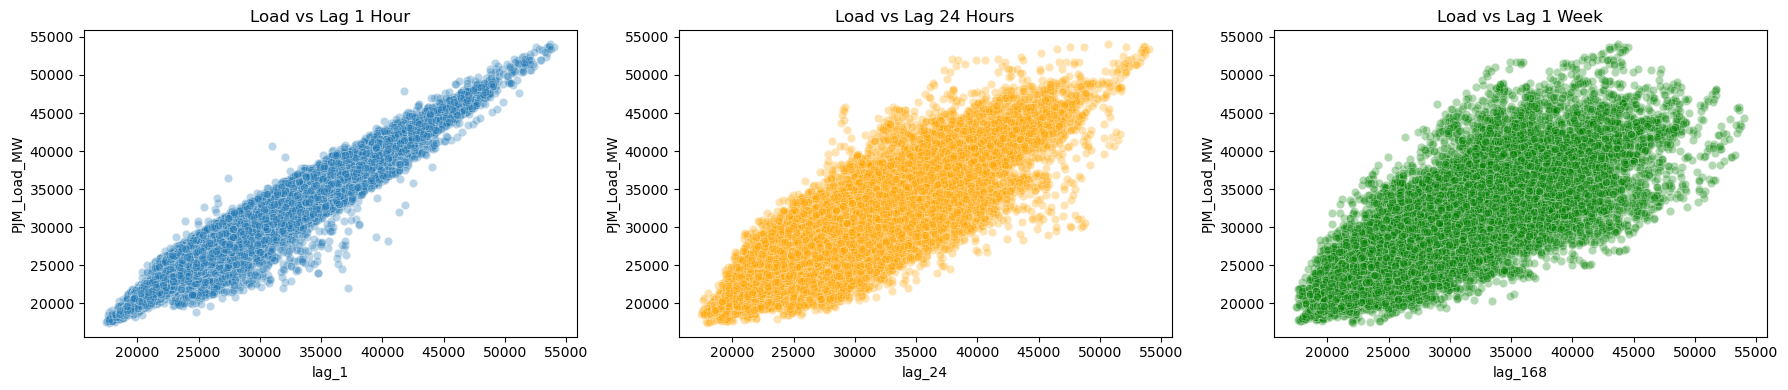

In [28]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.scatterplot(x='lag_1', y='PJM_Load_MW', data=df_feat, ax=axes[0], alpha=0.3)
axes[0].set_title('Load vs Lag 1 Hour')

sns.scatterplot(x='lag_24', y='PJM_Load_MW', data=df_feat, ax=axes[1], alpha=0.3, color='orange')
axes[1].set_title('Load vs Lag 24 Hours')

sns.scatterplot(x='lag_168', y='PJM_Load_MW', data=df_feat, ax=axes[2], alpha=0.3, color='green')
axes[2].set_title('Load vs Lag 1 Week')

plt.tight_layout()
plt.show()


## Step 5 – Time-Aware Validation and Baseline Model

To evaluate model performance fairly, we use `TimeSeriesSplit` to avoid data leakage across time.

We also build a simple lag-based baseline model:
> Predict current load using previous hour’s load (`lag_1`)



In [29]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define features and target
features = ['lag_1', 'lag_24', 'lag_168', 
            'rolling_mean_24', 'rolling_std_24',
            'rolling_mean_168', 'rolling_std_168',
            'hour', 'dayofweek']

X = df_feat[features].values
y = df_feat['PJM_Load_MW'].values

# Walk-forward cross-validation (5 splits)
tscv = TimeSeriesSplit(n_splits=5)
baseline_maes = []

for train_ix, val_ix in tscv.split(X):
    y_pred = X[val_ix, 0]
    mae = mean_absolute_error(y[val_ix], y_pred)
    baseline_maes.append(mae)

print(f'Naïve Baseline MAE (mean of folds): {np.mean(baseline_maes):.0f} MW')


Naïve Baseline MAE (mean of folds): 1088 MW


## Step 6 – Random Forest Forecasting with Walk-Forward Validation

We train a Random Forest model to predict hourly electricity load using lag, rolling, and calendar features.

We use walk-forward cross-validation (`TimeSeriesSplit`) to simulate real-time prediction and compare performance against the naive lag-based baseline.


In [30]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_maes = []

for train_ix, val_ix in tscv.split(X):
    X_train, X_val = X[train_ix], X[val_ix]
    y_train, y_val = y[train_ix], y[val_ix]
    
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    rf_maes.append(mae)

print(f'Random Forest MAE (mean of folds): {np.mean(rf_maes):.0f} MW')


Random Forest MAE (mean of folds): 452 MW


**Random Forest model reduced the prediction error to 452 MW, significantly outperforming the naive baseline (1088 MW) by learning from lag, trend, and time-based features.**


## Step 7 – Predictions and Feature Interpretation

To better understand model performance, we visualize:

1. **Predicted vs Actual Load** over time, to see how well the model tracks the real values.
2. **Feature importances**, to identify which lagged or time-based features contribute most to forecast accuracy.


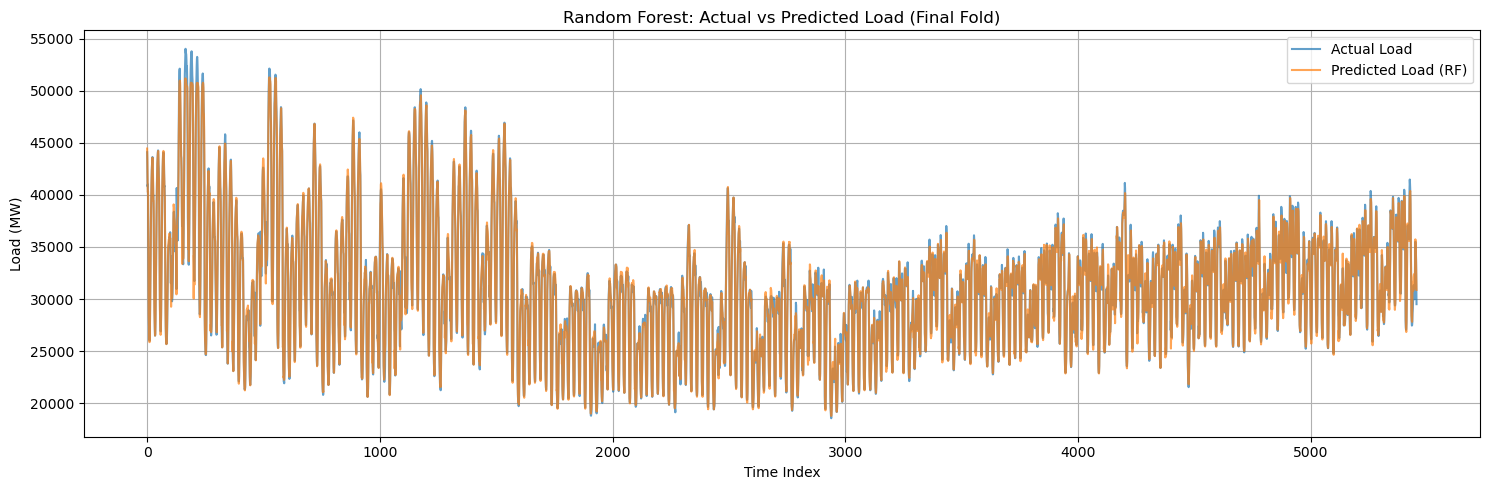

In [31]:
# Get final fold
for train_ix, val_ix in tscv.split(X):
    pass  # after the loop ends, train_ix and val_ix are from the last fold

X_train, X_val = X[train_ix], X[val_ix]
y_train, y_val = y[train_ix], y[val_ix]

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

# Plot predictions vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_val, label='Actual Load', alpha=0.7)
plt.plot(y_pred, label='Predicted Load (RF)', alpha=0.7)
plt.title('Random Forest: Actual vs Predicted Load (Final Fold)')
plt.xlabel('Time Index')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


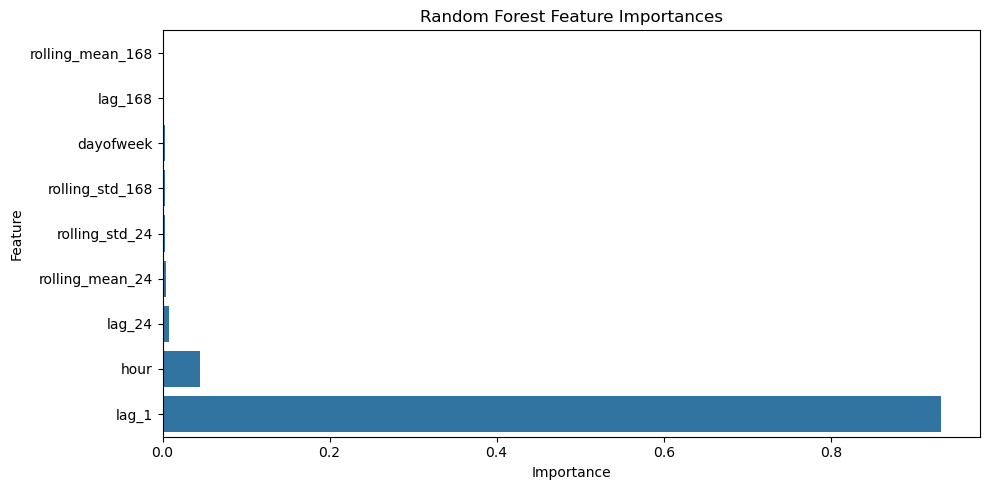

In [32]:
import pandas as pd
import seaborn as sns

# Get feature importances
importances = rf_model.feature_importances_
feature_names = features

feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance')

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()


- The Random Forest model tracks real electricity load closely, capturing both short-term fluctuations and longer-term patterns.
- `lag_1` (previous hour's load) is the most influential feature, confirming the value of autocorrelation in short-term forecasting.
- Time-based features like `hour` and `lag_24` also contribute meaningfully.
- Rolling statistics and long-term lags show lower importance, suggesting the model relies heavily on immediate past behavior.
